In [1]:
from cmdstanpy import CmdStanModel

import arviz as az
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import pandas as pd
import random as rd

In [2]:
df = pd.read_csv("output/caratPrice.csv")
df.head()

,carat,price
0,0.20,365.166667
1,0.21,380.222222
2,0.22,391.400000
3,0.23,486.143345
4,0.24,505.185039


### Model 1 - Linear regression

In [3]:
model_lr = CmdStanModel(stan_file='model_lr.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [4]:
result_lr = model_lr.sample(data=dict(N=len(df), x=df.carat.values, y=df.price.values))
print(result_lr.draws_pd())

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.



         lp__  accept_stat__  stepsize__  treedepth__  n_leapfrog__  \
0    -2680.24       1.000000    0.868633          2.0           3.0   
1    -2680.07       0.999927    0.868633          2.0           7.0   
2    -2681.32       0.872351    0.868633          2.0           3.0   
3    -2682.97       0.857444    0.868633          2.0           3.0   
4    -2680.48       0.908136    0.868633          2.0           3.0   
...       ...            ...         ...          ...           ...   
3995 -2681.41       0.916259    0.703351          3.0           7.0   
3996 -2681.52       0.965638    0.703351          3.0           7.0   
3997 -2681.14       1.000000    0.703351          2.0           3.0   
3998 -2681.94       0.962682    0.703351          3.0           7.0   
3999 -2680.37       0.999809    0.703351          2.0           7.0   

      divergent__  energy__    alpha     beta    sigma  ...  y_sim[264]  \
0             0.0   2682.40  215.809  5613.64  1349.59  ...     21170.2

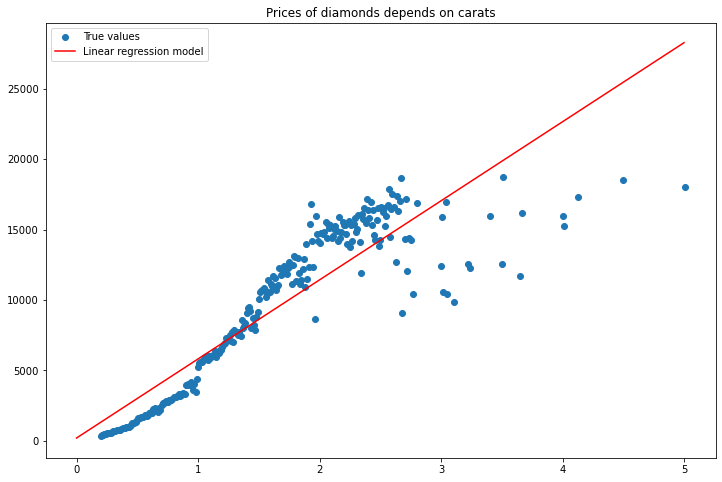

In [5]:
df_alpha = pd.DataFrame(result_lr.stan_variables()["alpha"])
df_beta = pd.DataFrame(result_lr.stan_variables()["beta"])
df_sigma = pd.DataFrame(result_lr.stan_variables()["sigma"])

alpha = df_alpha.mean().to_numpy()
beta = df_beta.mean().to_numpy()
sigma= df_sigma.mean().to_numpy()

x = np.linspace(0, 5, 100)
y = alpha + beta*x

plt.figure(figsize=[12, 8])
plt.scatter(df.carat.values, df.price.values)
plt.plot(x, y, "-r")
plt.title("Prices of diamonds depends on carats")
plt.legend(["True values", "Linear regression model"])
plt.show()

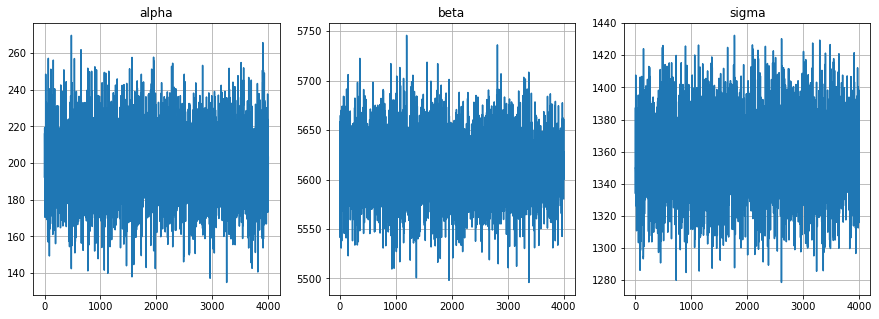

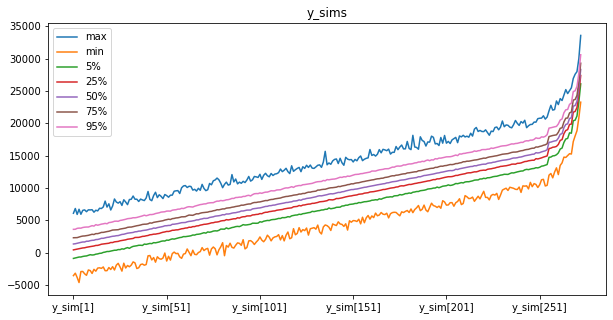

In [6]:
fig, axs = plt.subplots(1,3)
fig.set_size_inches(15, 5)
axs[0].plot(df_alpha)
axs[0].grid()
axs[0].set_title('alpha')
axs[1].plot(df_beta)
axs[1].grid()
axs[1].set_title('beta')
axs[2].plot(df_sigma)
axs[2].grid()
axs[2].set_title('sigma')
plt.show()

data = result_lr.draws_pd()
y_sims = data[data.columns[10:]]

quans = pd.DataFrame({'max': y_sims.max(), 'min': y_sims.min(), '5%': y_sims.quantile(0.05), '25%': y_sims.quantile(0.25), '50%': y_sims.quantile(0.5), '75%': y_sims.quantile(0.75), '95%': y_sims.quantile(0.95)})
quans.plot(figsize=(10,5))
plt.title("y_sims")
plt.show()

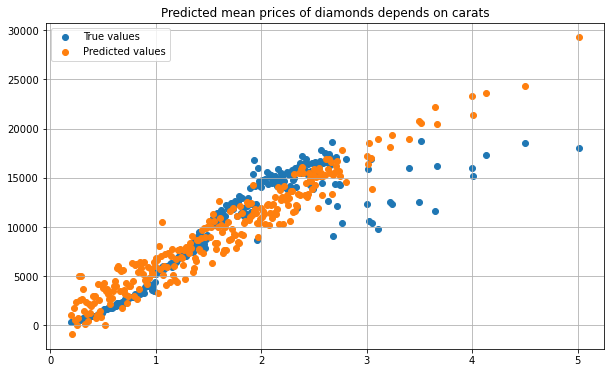

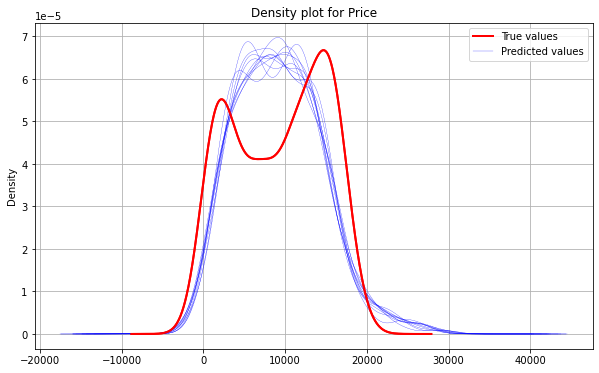

In [7]:
y_sim = result_lr.stan_variable('y_sim')
plt.figure(figsize=[10,6])
plt.scatter(df.carat.values, df.price.values)
plt.scatter(df.carat.values, y_sim[1])
plt.title("Predicted mean prices of diamonds depends on carats")
plt.legend(["True values", "Predicted values"])
plt.grid()
plt.show()


df.price.plot.density(figsize=(10,6), linewidth=2, color='red')
for i in range(0,10):
    y_sims.iloc[i].plot.density(linewidth=0.25, color='blue')
df.price.plot.density(figsize=(10,6), linewidth=2, color='red')
plt.title('Density plot for Price')
plt.legend(["True values", "Predicted values"])
plt.grid()
plt.show()

### Model 2 - Polynomial regression

In [8]:
model_pr = CmdStanModel(stan_file='model_pr.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [9]:
result_pr = model_pr.sample(data=dict(N=len(df), x=df.carat.values, y=df.price.values))
print(result_pr.draws_pd())

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.



         lp__  accept_stat__  stepsize__  treedepth__  n_leapfrog__  \
0    -3113.68       0.741302    0.066343          6.0          63.0   
1    -3114.52       0.931858    0.066343          6.0          63.0   
2    -3112.28       0.995770    0.066343          6.0          63.0   
3    -3112.20       0.727353    0.066343          5.0          39.0   
4    -3112.68       0.886240    0.066343          4.0          31.0   
...       ...            ...         ...          ...           ...   
3995 -3115.99       0.999569    0.062344          6.0          63.0   
3996 -3114.08       0.952133    0.062344          6.0          63.0   
3997 -3113.53       0.889919    0.062344          6.0          63.0   
3998 -3113.15       0.972511    0.062344          6.0          63.0   
3999 -3113.69       0.970323    0.062344          6.0          63.0   

      divergent__  energy__    alpha   beta_1   beta_2  ...  y_sim[264]  \
0             0.0   3120.89  568.159 -4022.42  12937.3  ...     14361.2

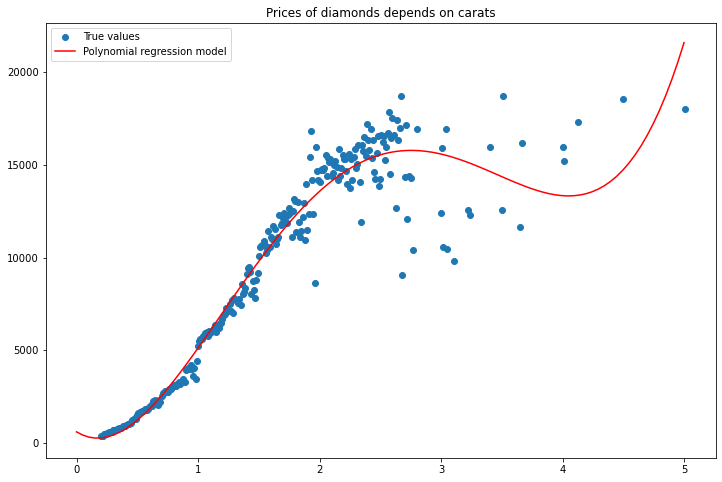

In [10]:
df_alpha = pd.DataFrame(result_pr.stan_variables()["alpha"])
df_beta_1 = pd.DataFrame(result_pr.stan_variables()["beta_1"])
df_beta_2 = pd.DataFrame(result_pr.stan_variables()["beta_2"])
df_beta_3 = pd.DataFrame(result_pr.stan_variables()["beta_3"])
df_beta_4 = pd.DataFrame(result_pr.stan_variables()["beta_4"])
df_sigma = pd.DataFrame(result_pr.stan_variables()["sigma"])

alpha = df_alpha.mean().to_numpy()
beta_1 = df_beta_1.mean().to_numpy()
beta_2 = df_beta_2.mean().to_numpy()
beta_3 = df_beta_3.mean().to_numpy()
beta_4 = df_beta_4.mean().to_numpy()

sigma= df_sigma.mean().to_numpy()

x = np.linspace(0, 5, 100)
y = alpha + beta_1*x + beta_2*(x**2) + beta_3*(x**3) + beta_4*(x**4)

plt.figure(figsize=[12, 8])
plt.scatter(df.carat.values, df.price.values)
plt.plot(x, y, "-r")
plt.title("Prices of diamonds depends on carats")
plt.legend(["True values", "Polynomial regression model"])
plt.show()

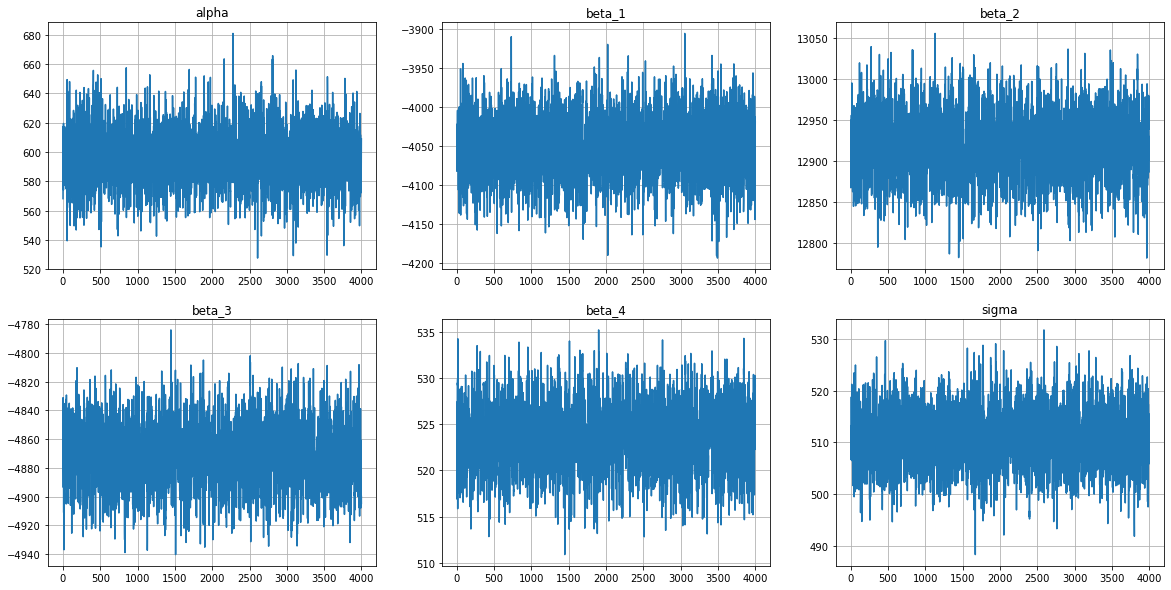

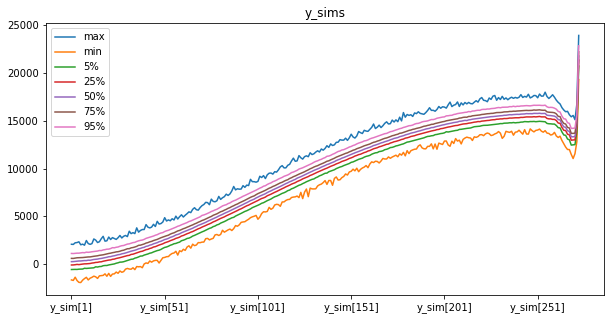

In [11]:
fig, axs = plt.subplots(2,3)
fig.set_size_inches(20, 10)
axs[0][0].plot(df_alpha)
axs[0][0].grid()
axs[0][0].set_title('alpha')
axs[0][1].plot(df_beta_1)
axs[0][1].grid()
axs[0][1].set_title('beta_1')
axs[0][2].plot(df_beta_2)
axs[0][2].grid()
axs[0][2].set_title('beta_2')
axs[1][0].plot(df_beta_3)
axs[1][0].grid()
axs[1][0].set_title('beta_3')
axs[1][1].plot(df_beta_4)
axs[1][1].grid()
axs[1][1].set_title('beta_4')
axs[1][2].plot(df_sigma)
axs[1][2].grid()
axs[1][2].set_title('sigma')
plt.show()

data = result_pr.draws_pd()
y_sims = data[data.columns[13:]]

quans = pd.DataFrame({'max': y_sims.max(), 'min': y_sims.min(), '5%': y_sims.quantile(0.05), '25%': y_sims.quantile(0.25), '50%': y_sims.quantile(0.5), '75%': y_sims.quantile(0.75), '95%': y_sims.quantile(0.95)})
quans.plot(figsize=(10,5))
plt.title("y_sims")
plt.show()

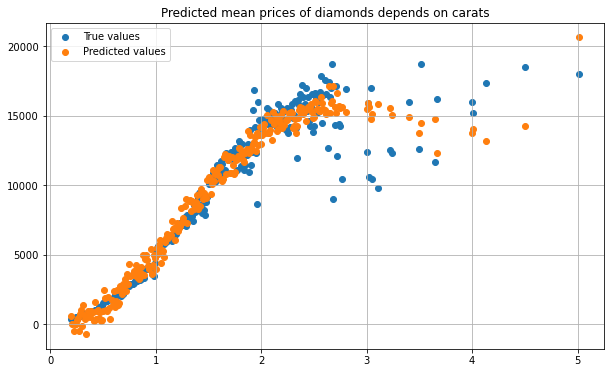

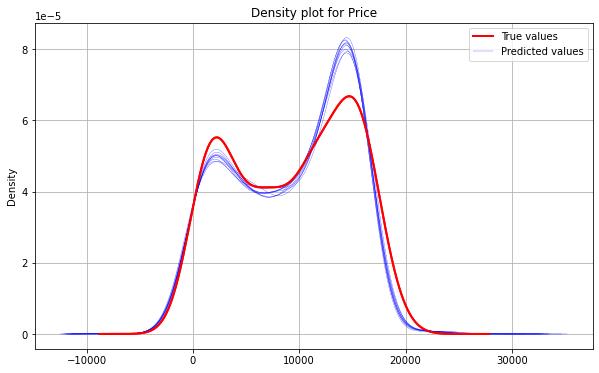

In [12]:
y_sim = result_pr.stan_variable('y_sim')

plt.figure(figsize=[10,6])
plt.scatter(df.carat.values, df.price.values)
plt.scatter(df.carat.values, y_sim[1])
plt.title("Predicted mean prices of diamonds depends on carats")
plt.legend(["True values", "Predicted values"])
plt.grid()
plt.show()


df.price.plot.density(figsize=(10,6), linewidth=2, color='red')
for i in range(0,10):
    y_sims.iloc[i].plot.density(linewidth=0.25, color='blue')
df.price.plot.density(figsize=(10,6), linewidth=2, color='red')
plt.title('Density plot for Price')
plt.legend(["True values", "Predicted values"])
plt.grid()
plt.show()

### Model 3 - Gaussian process

In [13]:
model_gp_opt = CmdStanModel(stan_file='model_gp_opt.stan')
data = dict(N = len(df), x = df.carat.values, y = df.price.values)
result_gp_opt = model_gp_opt.optimize(data=data, algorithm='Newton')

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing


In [19]:
model_gp = CmdStanModel(stan_file='model_gp.stan')

INFO:cmdstanpy:compiling stan file E:\Programowanie\Microsoft VS Code Projects\Data Analytics\DA_DiamondModel\model_gp.stan to exe file E:\Programowanie\Microsoft VS Code Projects\Data Analytics\DA_DiamondModel\model_gp.exe
INFO:cmdstanpy:compiled model executable: E:\Programowanie\Microsoft VS Code Projects\Data Analytics\DA_DiamondModel\model_gp.exe
--- Translating Stan model to C++ code ---
bin/stanc.exe  --o=C:/Users/Marcin/AppData/Local/Temp/tmpw4xkltwj/tmp1r12qpxv.hpp C:/Users/Marcin/AppData/Local/Temp/tmpw4xkltwj/tmp1r12qpxv.stan
Warning in 'C:/Users/Marcin/AppData/Local/Temp/tmpw4xkltwj/tmp1r12qpxv.stan', line 3, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in 'C:/Users/Marcin/AppData/Local/Temp/tmpw4xkltwj/tmp1r12qpxv.stan', line 4, column 4: Declaration
    of

In [51]:
"""
result = result_gp_opt.optimized_params_pd

alpha = float(result['alpha'])
rho = float(result['rho'])
sigma = float(result['sigma'])

print(alpha)
print(rho)
print(sigma)
"""
alpha = 130
rho = 1
sigma = 100


In [52]:
idx = range(1, len(df.price.values)+1)
data = dict(N = len(df), x = df.carat.values, y = df.price.values, idx = idx, rho=rho, alpha=alpha, sigma=sigma)
result_gp = model_gp.sample(data=data)

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


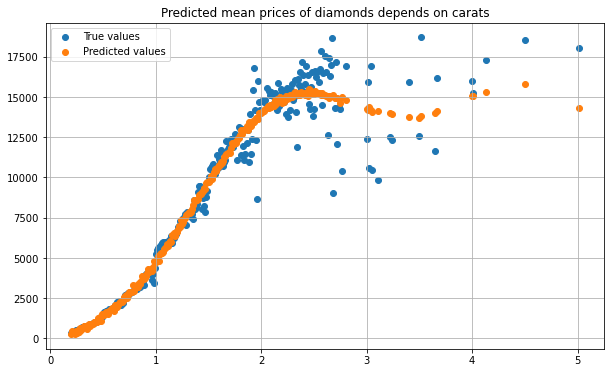

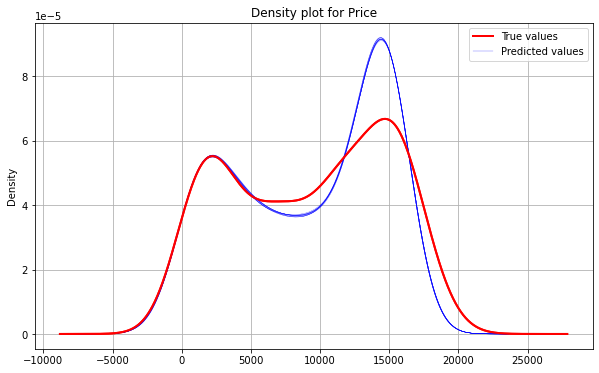

In [53]:
data = result_gp.draws_pd()
y_sims = data[data.columns[553:]]
y_sim = result_gp.stan_variable('y_sim')

plt.figure(figsize=[10,6])
plt.scatter(df.carat.values, df.price.values)
plt.scatter(df.carat.values, y_sim[0])
plt.title("Predicted mean prices of diamonds depends on carats")
plt.legend(["True values", "Predicted values"])
plt.grid()
plt.show()

df.price.plot.density(figsize=(10,6), linewidth=2, color='red')
for i in range(0,10):
    y_sims.iloc[i].plot.density(linewidth=0.25, color='blue')
df.price.plot.density(figsize=(10,6), linewidth=2, color='red')
plt.title('Density plot for Price')
plt.legend(["True values", "Predicted values"])
plt.grid()
plt.show()

### Comparison of models

In [54]:
data = dict(model_lr_ = result_lr, model_pr_ = result_pr, model_gp_ = result_gp)
comp_loo = az.compare(data, ic = "loo")
print('\n')
print(comp_loo)
az.plot_compare(comp_loo)

e:\Programowanie\Anaconda\envs\marcinbereznicki\lib\site-packages\arviz\stats\stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(


TypeError: log likelihood not found in inference data object

In [55]:
comp_waic = az.compare(data, ic = "waic")
print('\n')
print(comp_waic)
az.plot_compare(comp_waic)

TypeError: log likelihood not found in inference data object